# Chemprop functions

## Setup

In [ ]:
!pip install descriptastorus chemprop rdkit -qq #rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import chemprop, pandas as pd, numpy as np

from rdkit import Chem
from rdkit.Chem import SaltRemover, MolStandardize

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA

In [ ]:
def preprocess_smiles(smiles):
    try:
        # Convert to a molecule object
        mol = Chem.MolFromSmiles(smiles)
        if not mol:
            return None

        # Standardization, get largest fragment
        lfc = MolStandardize.fragment.LargestFragmentChooser()
        mol = lfc.choose(mol)

        # Normalize
        norm = MolStandardize.normalize.Normalizer()
        mol = norm.normalize(mol)

        # # Desalt, duplicates with largest fragment
        # remover = SaltRemover.SaltRemover()
        # mol = remover.StripMol(mol, dontRemoveEverything=True)

        # Neutralization
        uncharger = MolStandardize.charge.Uncharger()
        mol = uncharger.uncharge(mol)

        # Convert back to SMILES
        standardized_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
        return standardized_smiles
    except Exception as e:
        print(f"An error occurred for SMILES {smiles}: {e}")
        return None

In [ ]:
def preprocess_smi_df(df,smi_col):
  df = df.copy()
  print('before:',df.shape)
  df[smi_col] = df[smi_col].apply(preprocess_smiles)
  df = df.dropna(subset=smi_col).reset_index(drop=True)
  print('after:',df.shape)
  return df

## Load Data

In [ ]:
df = pd.read_parquet('tox21_MMP_inactive_and_antagonist.parquet')
df = preprocess_smi_df(df,'SMILES')
df[['SMILES','target']].to_csv('train.csv',index=False)

before: (5748, 7)


[17:20:08] Can't kekulize mol.  Unkekulized atoms: 3 10


after: (5748, 7)


In [ ]:
df = pd.read_csv('all.csv')
df = preprocess_smi_df(df,'SMILES')

before: (1410, 5)
after: (1410, 5)


In [ ]:
df.to_csv('all2.csv',index=False)

In [ ]:
df.IC50.apply(lambda x: -np.log10(x))

0       1.00000
1       0.39794
2       0.39794
3       0.39794
4       0.39794
         ...   
1405        NaN
1406        NaN
1407        NaN
1408        NaN
1409        NaN
Name: IC50, Length: 1410, dtype: float64

<Axes: xlabel='Kd', ylabel='IC50'>

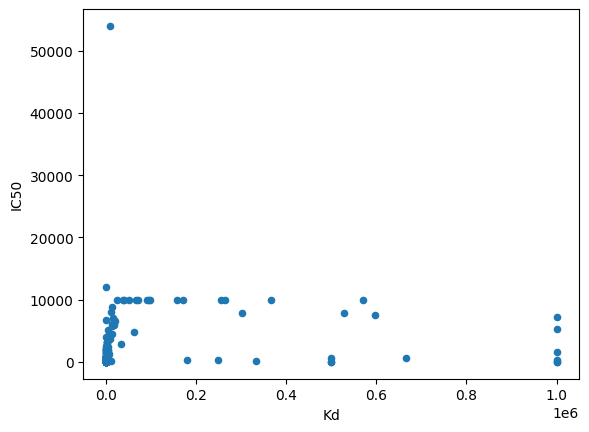

In [ ]:
df.plot.scatter('Kd','IC50')

In [ ]:
def get_unique(x): return x

In [ ]:
d = df.groupby('SMILES').agg({'ID': get_unique, 'Kd': get_unique, 'IC50': get_unique, 'erk_IC50': get_unique})

In [ ]:
d

,ID,Kd,IC50,erk_IC50
SMILES,,,,
Brc1cc(N2CCc3c(nc(OCC45CCCN4CCC5)nc3N3C[C@H]4CC[C@@H](C3)N4)C2)c2ccccc2c1,646_111,NaN,1052.0,NaN
Brc1ccc(N2CCc3c(nc(OCC45CCCN4CCC5)nc3N3C[C@H]4CC[C@@H](C3)N4)C2)c2ccccc12,646_112,NaN,5456.6,16667.0
C#CCc1ccc(O)cc1-c1ncc2c(N3CC4CCC(C3)N4)nc(OCC34CCCN3CCC4)nc2c1F,US_279,NaN,1.6,7401.8
C#Cc1c(F)ccc2cc(O)cc(-c3ncc4c(N5CC6CC(O)CC5C6)nc(OC[C@@]56CCCN5C[C@H](F)C6)nc4c3F)c12,azaq_390,NaN,2.0,NaN
C#Cc1c(F)ccc2cc(O)cc(-c3ncc4c(N5CC6CCC(C5)N6)nc(OCC56CCCN5CCC6)nc4c3F)c12,US_232,NaN,0.6,15.2
...,...,...,...,...
[O-][S+]1CCC(Oc2nc(N3CC4CCC(C3)N4)c3cnc(-c4cc(O)cc5ccccc45)c(F)c3n2)CC1,US_82,214.8,226.8,16666.7
c1cc2c(c(N3CCc4c(nc(OCC56CCCN5CCC6)nc4N4C[C@H]5CC[C@@H](C4)N5)C3)c1)C(C1CC1)CC2,646_102,NaN,654.1,NaN
c1cc2c(c(N3CCc4c(nc(OCC56CCCN5CCC6)nc4N4C[C@H]5CC[C@@H](C4)N5)C3)c1)CCC2,646_104,NaN,755.6,NaN


In [ ]:
d['ID_len'] = d.ID.apply(len)
d['Kd_len'] = d.Kd.apply(len)
d['IC50'] = d.IC50.apply(len)
d['erk_IC50'] = d.erk_IC50.apply(len)

In [ ]:
d.sort_values('ID_len',ascending=False)[:20]

,ID,Kd,IC50,erk_IC50,ID_len,Kd_len
SMILES,,,,,,
CCc1cccc2cccc(N3CCc4c(nc(OCC56CCCN5CCC6)nc4N4CCC(O)CC(CO)C4)C3)c12,"[tetra_172, tetra_174, tetra_173]",[nan],3,1,3,1
CN(C)C(=O)c1cc2n(n1)CCCN(c1nc(OCC34CCCN3C/C(=C\F)C4)nc3c(F)c(-c4ccc(F)c5sc(N)c(C#N)c45)c(Cl)cc13)C2,"[quina_156, quina_157]",[nan],1,1,2,1
CCc1c(F)ccc2cc(O)cc(-c3ncc4c(N5CC6CC(O)C(C6)C5)nc(OC[C@@]56CCCN5C[C@H](F)C6)nc4c3F)c12,"[azaq_140, azaq_82]",[nan],1,2,2,1
CCc1cccc2cccc(N3CCc4c(nc(OCC56CCCN5CCC6)nc4N4CCCC(c5cn(C)nn5)C4)C3)c12,"[tetra_119, tetra_118]",[nan],2,1,2,1
C=C1CN2CC(=C)CC2(COc2nc(N3CCC[C@@](C)(O)C3)c3cc(F)c(-c4cc(O)cc5ccc(F)c(CC)c45)c(F)c3n2)C1,"[quina_117A, quina_117B]",[nan],2,1,2,1
Cc1cc2c(N3CCC[C@@](C)(O)C3)nc(OC[C@@]34CCCN3C[C@H](F)C4)nc2c(F)c1-c1ccc(F)c2sc(N)c(C#N)c12,"[quina_124A, quina_124B]",[nan],2,1,2,1
C[C@@]1(O)CCCN(c2nc(OCC34CCCN3CC(=C(F)F)C4)nc3c(F)c(-c4ccc(F)c5sc(N)c(C#N)c45)c(Cl)cc23)C1,"[quina_143A, quina_143B]",[nan],2,1,2,1
OC1CCCN(c2nc(OCC34CCCN3CCC4)nc3c(F)c(-c4cccc5cccc(F)c45)ncc23)CC1,"[azaq_8, azaq_129]",[nan],2,1,2,1
CN(C)C(=O)c1cc2n(n1)CCCN(c1nc(OC[C@@]34CCCN3C[C@H](F)C4)nc3c(F)c(-c4ccc(F)c5sc(N)c(C#N)c45)c(Cl)cc13)C2,"[quina_136B, quina_136A]",[nan],2,1,2,1


In [ ]:
df.groupby('SMILES').agg({'ID':'list','Kd':'list'})

AttributeError: 'SeriesGroupBy' object has no attribute 'list'

## Function & Use

In [ ]:
def train_file(train_file: str, # filename
               valid_file:str,
               test_file:str,
               task: str, # "regression" or "classification"
               ckp_folder: str, # checkpoint folder name
               epochs: str, # default for chemprop is 30
               seed: str = '0'
               ):
  "Use Chemprop to train a file with first column as smiles, and the rest columns as target, with header row"

  arguments = [
    '--data_path', train_file,
    '--dataset_type', task,
    '--save_dir', ckp_folder,
    '--epochs', epochs,
    '--seed', seed,
    '--save_smiles_splits',
    '--quiet', #  quiet

    # extra metrics for classification
    '--extra_metrics', 'prc-auc',

    # for splitting
    '--split_type', 'scaffold_balanced',


    # if customize split, need to indicate valid and test file
    # '--separate_val_path', valid_file,
    # '--separate_test_path', test_file,



    # for generating RDKit features, comment out if not needed
    # '--features_generator', 'rdkit_2d_normalized',
    # '--no_features_scaling'

    # alternatively, generate features in advance
    # '--features_path', <csv/npy file>, '--no_features_scaling'

    # if hyperopt
    # '--config_path', <config path>
  ]

  args = chemprop.args.TrainArgs().parse_args(arguments)
  mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

  return mean_score,std_score

In [ ]:
# To optimize model parameter, to use it in training, add it to --config_path in training
# !chemprop_hyperopt --data_path <input_file.csv> --dataset_type <reg./class.> --num_iters <10> --config_save_path <folder>


In [ ]:
mean,_ = train_file('train.csv','train.csv','train.csv','classification','ckp','25','123')

5748it [00:00, 22359.35it/s]
100%|██████████| 5748/5748 [00:01<00:00, 4028.73it/s]
Fold 0
100%|██████████| 5748/5748 [00:00<00:00, 7764.33it/s]
5748it [00:00, 348706.35it/s]
100%|██████████| 92/92 [00:12<00:00,  4.42it/s]
                                               
100%|██████████| 92/92 [00:04<00:00, 19.01it/s]
                                               
100%|██████████| 92/92 [00:06<00:00, 19.88it/s]
                                               
100%|██████████| 92/92 [00:04<00:00, 19.37it/s]
                                               
100%|██████████| 92/92 [00:05<00:00, 20.35it/s]
                                               
 98%|█████████▊| 90/92 [00:04<00:00, 20.83it/s]
                                               
 98%|█████████▊| 90/92 [00:05<00:00, 20.06it/s]
                                               
100%|██████████| 92/92 [00:05<00:00, 10.53it/s]
                                               
 99%|█████████▉| 91/92 [00:05<00:00, 19.79it/s]
          

In [ ]:
# To compare with original command
# !chemprop_train --data_path 'SAMPL.csv' --dataset_type 'regression' --save_dir 'ckp2' --epochs '10' --separate_val_path 'SAMPL.csv' --separate_test_path 'SAMPL.csv'

In [ ]:
def predict_file(input_file:str, # filename, with first column as smiles
                 ckp_folder: str, # checkpoint folder name
                 return_df=True
                 ):

  "Load trained models and make predictions on csv file that contains SMILES in the first column"
  arguments = [
    '--test_path', input_file,
    '--preds_path', '/dev/null',
    '--checkpoint_dir', ckp_folder,

    # for generating RDKit features, comment out if not needed
    # '--features_generator', 'rdkit_2d_normalized', # for generating RDKit features
    # '--no_features_scaling',

    ]

  args = chemprop.args.PredictArgs().parse_args(arguments)
  preds = chemprop.train.make_predictions(args=args)

  preds = np.array(preds).squeeze()

  if return_df:
    preds = pd.DataFrame(preds)
    preds.columns = 'pred_'+preds.columns.astype(str)
    df = pd.read_csv(input_file)
    df = pd.concat([df,preds],axis=1)
    return df

  else:
    return preds

In [ ]:
out = predict_file('/content/ckp3/fold_0/test_full.csv','ckp3')

Loading training args
Setting molecule featurization parameters to default.
Loading data


576it [00:00, 120320.69it/s]
100%|██████████| 576/576 [00:00<00:00, 113285.15it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validating SMILES
Test size = 576


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda



100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

Saving predictions to /dev/null
Elapsed time = 0:00:03


In [ ]:
out = out.rename(columns={'pred_0':'pred'})

In [ ]:
df= out.copy()

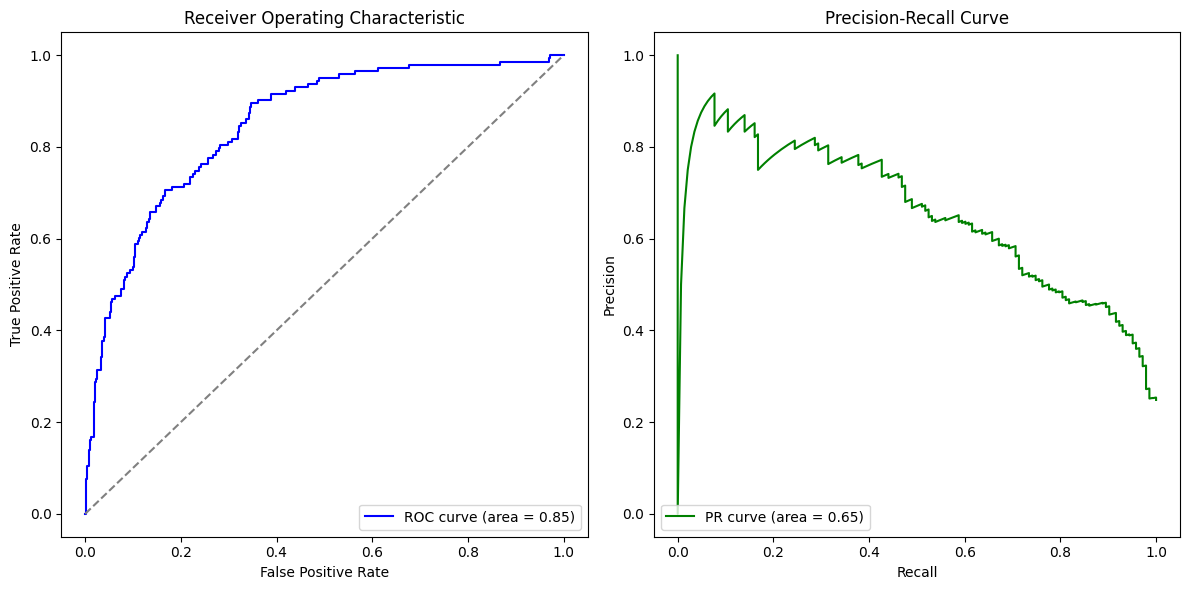

In [ ]:
# Compute ROC Curve and AUC
fpr, tpr, _ = roc_curve(df['target'], df['pred'])
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall Curve and AUPRC
precision, recall, _ = precision_recall_curve(df['target'], df['pred'])
pr_auc = auc(recall, precision)

# Plotting ROC Curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Plotting Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

In [ ]:
def predict_smiles(smiles: list,  # need to in format: [['CCC'], ['CCCC'], ['OCC']]
                   ckp_folder: str, # checkpoint folder name
                   ):

  "Load trained models and make predictions on SMILES"

  arguments = [
      '--test_path', '/dev/null',
      '--preds_path', '/dev/null',
      '--checkpoint_dir', ckp_folder,

      # for generating RDKit features
      # '--features_generator', 'rdkit_2d_normalized',
      # '--no_features_scaling'

      ]

  args = chemprop.args.PredictArgs().parse_args(arguments)
  model_objects = chemprop.train.load_model(args=args)

  preds = chemprop.train.make_predictions(args=args, smiles=smiles, model_objects=model_objects)

  return preds

In [ ]:
a = []
for s in ['Clc1cc(cc(c1)Cl)NS(=O)(=O)c1c(C)c(C)c(c(c1C)C)C','Clc1cc(ccc1F)NS(=O)(=O)c1cc(C)c(c(c1)C)F']:
  a.append([preprocess_smiles(s)])

In [ ]:
a

[['Cc1c(C)c(C)c(S(=O)(=O)Nc2cc(Cl)cc(Cl)c2)c(C)c1C'],
 ['Cc1cc(S(=O)(=O)Nc2ccc(F)c(Cl)c2)cc(C)c1F']]

In [ ]:
predict_smiles(a,'ckp')

Loading training args


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 2


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

Saving predictions to /dev/null
Elapsed time = 0:00:01


[[0.33095455169677734], [0.27109837532043457]]

## Linux command

In [ ]:
# Train
!chemprop_train --data_path <path> --dataset_type <type> --save_dir <dir>

In [ ]:
!chemprop_interpret --data_path <csv file name> --checkpoint_dir <tox21_checkpoints/fold_0/> --property_id 1

In [ ]:
# def plot_parity(y_true, y_pred, y_pred_unc=None):

#     axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
#     axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))

#     mae = mean_absolute_error(y_true, y_pred)
#     rmse = mean_squared_error(y_true, y_pred, squared=False)

#     plt.plot([axmin, axmax], [axmin, axmax], '--k')

#     plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', alpha=1, elinewidth=1)

#     plt.xlim((axmin, axmax))
#     plt.ylim((axmin, axmax))

#     ax = plt.gca()
#     ax.set_aspect('equal')

#     at = AnchoredText(
#     f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}", prop=dict(size=10), frameon=True, loc='upper left')
#     at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#     ax.add_artist(at)

#     plt.xlabel('True')
#     plt.ylabel('Chemprop Predicted')

#     plt.show()

#     return

# Train regression model

In [ ]:
arguments = [
    '--data_path', 'SAMPL.csv',
    '--dataset_type', 'regression',
    '--save_dir', 'checkpoint_regression',
    '--epochs', '5',
    '--save_smiles_splits'
]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

# Predict from file

In [ ]:
arguments = [
    '--test_path', 'SAMPL_smiles.csv',
    '--preds_path', 'SAMPL_pred2.csv',
    '--checkpoint_dir', 'checkpoint_regression'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)

Loading training args
Setting molecule featurization parameters to default.
Loading data


642it [00:00, 314683.09it/s]
100%|██████████| 642/642 [00:00<00:00, 156773.59it/s]


Validating SMILES
Test size = 642


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Saving predictions to SAMPL_pred2.csv
Elapsed time = 0:00:01


In [ ]:
df = pd.read_csv('checkpoint_regression/fold_0/test_full.csv')

In [ ]:
df

,smiles,expt,calc
0,CI,-0.89,-0.641
1,CCOCCOCC,-3.54,-3.420
2,C[C@@H](C(F)(F)F)O,-4.16,-3.518
3,COc1cccc(c1)N,-7.29,-7.201
4,CCCS,-1.10,-0.182
...,...,...,...
60,C1COCCN1,-7.17,-6.116
61,CC=C,1.32,2.328
62,CCCCCCCC=C,2.06,2.995
63,Cc1ccc(c2c1cccc2)C,-2.82,-3.081


In [ ]:

df['preds'] = [x[0] for x in preds]
df

,smiles,logSolubility,preds
0,C/C1CCC(\C)CC1,-4.470,-2.923179
1,Cc1ccc(OP(=O)(Oc2cccc(C)c2)Oc3ccccc3C)cc1,-6.010,-2.800287
2,c1c(Br)ccc2ccccc12,-4.400,-4.282761
3,CCOc1ccc(cc1)C(C)(C)COCc3cccc(Oc2ccccc2)c3,-8.600,-3.202824
4,CCC1(C(=O)NC(=O)NC1=O)C2=CCCCC2,-2.170,-2.961018
5,C(Cc1ccccc1)c2ccccc2,-4.620,-2.532373
6,Cc1cccc(N)c1,-0.850,-1.932497
7,CCN(CC(C)=C)c1c(cc(cc1N(=O)=O)C(F)(F)F)N(=O)=O,-6.124,-4.090992
8,CC(C)O,0.430,0.151779
9,CCCCCCCCO,-2.390,-3.121081


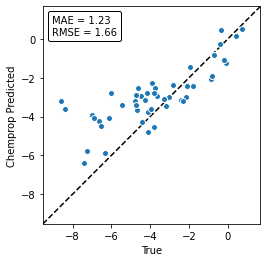

In [ ]:
plot_parity(df.logSolubility, df.preds)

# Predict from SMILES list

In [ ]:
smiles = [['CCC'], ['CCCC'], ['OCC']]

In [ ]:
arguments = [
    '--test_path', '/dev/null',
    '--preds_path', '/dev/null',
    '--checkpoint_dir', 'checkpoint_regression'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args, smiles=smiles)

Loading training args


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 3


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda



100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

Saving predictions to /dev/null
Elapsed time = 0:00:01


# Load model once, predict multiple times

In [ ]:
def predict_smiles(smiles: list,
                   ckp_folder: str):

  "Load trained models and make predictions on SMILES"

  arguments = [
      '--test_path', '/dev/null',
      '--preds_path', '/dev/null',
      '--checkpoint_dir', ckp_folder ]

  args = chemprop.args.PredictArgs().parse_args(arguments)
  model_objects = chemprop.train.load_model(args=args)

  preds = chemprop.train.make_predictions(args=args, smiles=smiles, model_objects=model_objects)

  return preds

  predict_smiles([['CCC'], ['CCCC'], ['OCC']],'checkpoint_regression')

Loading training args


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 3


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

Saving predictions to /dev/null
Elapsed time = 0:00:00


[[-0.04421087830522907, 1.020323459927889],
 [0.01709722950848258, 0.8331500234260298],
 [-3.4545247578611873, -2.629558922378509]]

In [ ]:
predict_smiles(['CCC', 'CCCC', 'OCC'],'checkpoint_regression')

Loading training args


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 3


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

Saving predictions to /dev/null
Elapsed time = 0:00:00


[[-2.4402600814455004, -1.7262390936005585],
 [-2.4402600814455004, -1.7262390936005585],
 [-4.311660863195077, -3.834710725970676]]

In [ ]:
arguments = [
    '--test_path', '/dev/null',
    '--preds_path', '/dev/null',
    '--checkpoint_dir', 'checkpoint_regression'
]

args = chemprop.args.PredictArgs().parse_args(arguments)

model_objects = chemprop.train.load_model(args=args)

Loading training args
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


In [ ]:
smiles = [['CCC'], ['CCCC'], ['OCC']]
preds = chemprop.train.make_predictions(args=args, smiles=smiles, model_objects=model_objects)

Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 3


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

Saving predictions to /dev/null
Elapsed time = 0:00:00


In [ ]:
smiles = [['CCCC'], ['CCCCC'], ['COCC']]
preds = chemprop.train.make_predictions(args=args, smiles=smiles, model_objects=model_objects)

Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 3


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

Saving predictions to /dev/null
Elapsed time = 0:00:00


In [ ]:
preds

[[0.017096773558996414, 0.8331500234260298],
 [-0.05130613623768632, 0.7277953384839071],
 [-2.140397378554609, -1.6481761812033]]

# Split Type

In [ ]:
def train_file(input_file,task,ckp_folder,epochs):
  arguments = [
    '--data_path', input_file,
    '--dataset_type', task,
    '--save_dir', ckp_folder,
    '--epochs', epochs,
    '--split_type', 'scaffold_balanced',
    '--save_smiles_splits'
  ]

  args = chemprop.args.TrainArgs().parse_args(arguments)
  mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

  return mean_score,std_score

In [ ]:
arguments = [
    '--data_path', 'data/regression.csv',
    '--dataset_type', 'regression',
    '--save_dir', 'test_checkpoints_splits',
    '--epochs', '5',
    '--split_type', 'scaffold_balanced',
    '--save_smiles_splits'
]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

In [ ]:
def predict_files(input_file,ckp_folder):
  arguments = [
    '--test_path', input_file,
    '--preds_path', '/dev/null',
    '--checkpoint_dir', ckp_folder]

  args = chemprop.args.PredictArgs().parse_args(arguments)
  preds = chemprop.train.make_predictions(args=args)

  return preds

In [ ]:
a = predict_files('SAMPL.csv','checkpoint_regression')

Loading training args
Setting molecule featurization parameters to default.
Loading data


642it [00:00, 284044.64it/s]
100%|██████████| 642/642 [00:00<00:00, 104224.46it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validating SMILES
Test size = 642


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda



100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

Saving predictions to /dev/null
Elapsed time = 0:00:02


# Ensembling and Uncertainty

In [ ]:
# arguments = [
#     '--data_path', 'data/reaction_regression.csv',
#     '--dataset_type', 'regression',
#     '--save_dir', 'test_checkpoints_ensemble',
#     '--epochs', '5',
#     '--reaction',
#     '--save_smiles_splits',
#     '--ensemble_size', '5',
#     '--split_type', 'scaffold_balanced'
# ]

# args = chemprop.args.TrainArgs().parse_args(arguments)
# mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

In [ ]:
# arguments = [
#     '--test_path', 'test_checkpoints_ensemble/fold_0/test_smiles.csv',
#     '--preds_path', 'test_preds_ensemble.csv',
#     '--checkpoint_dir', 'test_checkpoints_ensemble',
#     '--ensemble_variance'
# ]

# args = chemprop.args.PredictArgs().parse_args(arguments)
# preds = chemprop.train.make_predictions(args=args)

In [ ]:
preds_df = pd.read_csv('test_preds_ensemble.csv')
preds_df

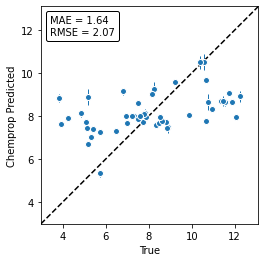

In [ ]:
df = pd.read_csv('test_checkpoints_ensemble/fold_0/test_full.csv')
plot_parity(df.ea, preds_df.ea, preds_df.ea_ensemble_uncal_var)

# Pretraining / Transfer Learning

In [ ]:
def train_file(input_file,task,ckp_folder,epochs):
  arguments = [
    '--data_path', input_file,
    '--dataset_type', task,
    '--save_dir', ckp_folder,
    '--epochs', epochs,
    '--save_smiles_splits'
  ]

  args = chemprop.args.TrainArgs().parse_args(arguments)
  mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

  return mean_score,std_score

In [ ]:
_,_ = train_file('SAMPL.csv','regression','ckp','5')

Command line
python /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-7e38205e-f5ea-4a6c-8cc1-5e707dc0d53f.json
Args
{'activation': 'ReLU',
 'adding_bond_types': True,
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_constraints': [],
 'atom_descriptor_scaling': True,
 'atom_descriptors': None,
 'atom_descriptors_path': None,
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'atom_targets': [],
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_constraints': [],
 'bond_descriptor_scaling': True,
 'bond_descriptors': None,
 'bond_descriptors_path': None,
 'bond_descriptors_size': 0,
 'bond_features_size': 0,
 'bond_targets': [],
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': False,
 'config_path': None,
 'constraints_path': None,
 'crossval_index_dir': None,

In [ ]:
arguments = [
    '--data_path', 'data/regression.csv',
    '--dataset_type', 'regression',
    '--save_dir', 'test_checkpoints_transfer',
    '--epochs', '5',
    '--save_smiles_splits'
]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

Command line
python /usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-8f687a13-fd1d-4bb6-bf15-8368444c40f1.json
Args
{'activation': 'ReLU',
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_descriptor_scaling': True,
 'atom_descriptors': None,
 'atom_descriptors_path': None,
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_feature_scaling': True,
 'bond_features_path': None,
 'bond_features_size': 0,
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': False,
 'config_path': None,
 'crossval_index_dir': None,
 'crossval_index_file': None,
 'crossval_index_sets': None,
 'cuda': False,
 'data_path': 'data/regression.csv',
 'data_weights_path': None,
 'dataset_type': 'regression',
 'depth': 3,
 'depth_solvent': 3,
 'devi

For transfer learning, add --checkpoint_frzn, and model.pt path as additional arguments.